## 0. Import Libraries

In [2]:
from datetime import datetime, timedelta
from glob import glob

import numpy as np
import pandas as pd
import pyproj
import rioxarray
import salem
import xarray as xr
from shapely.geometry import mapping

import cartopy
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import proplot
from matplotlib.colors import BoundaryNorm, ListedColormap
from cartopy.feature import ShapelyFeature
from cartopy.io.shapereader import Reader
from dea_tools.spatial import xr_vectorize, xr_rasterize
from wrf import getvar, interpline, CoordPair, xy_to_ll, ll_to_xy 

import warnings
warnings.filterwarnings('ignore')

## 1. Data Options

In [3]:
variables = ['theta_e', 'wa']
run_season = 'spring'
general_path = 'data'

# ensemble members
micro_options = [
    'lin',
    'thompson',
    'wsm6'
]

luse_options = [
    'urban',
    'nourban'
]

## 2. Open and Merge Datasets

In [4]:
# dicts to accumulate data
dt_ens_mean_var = {}
    
# loop over variables
for variable in variables:
        
    # data path
    data_path = glob(fr'{general_path}/*{run_season}**{variable}*')

    # open data
    dt = xr.open_mfdataset(data_path,
                           concat_dim='ens')[variable]

    # define ensemble members
    # ensemble member list
    ensemble_members = list(dt.ens.values)

    # urban and nourban members
    urban_members = [ens for ens in ensemble_members if not 'nourban' in ens ]
    nourban_members = [ens for ens in ensemble_members if 'nourban' in ens ]

    # calculate urban and nourban ensembles
    dt_urban_ens = dt.sel(ens=urban_members).mean(dim='ens')
    dt_nourban_ens = dt.sel(ens=nourban_members).mean(dim='ens')  
    
    dt_ens_mean_var[variable] = [dt_urban_ens, dt_nourban_ens]

In [5]:
# topography data
hgt_data = xr.open_dataset('data/HGT_d03.nc')['HGT']
# assign projection and dim info
hgt_data = hgt_data.rio.write_crs(hgt_data.attrs['pyproj_srs'])
hgt_data = hgt_data.rio.set_spatial_dims(x_dim='west_east',
                             y_dim='south_north')

In [6]:
bottom_hgt_list = []
dt_tempor = dt_ens_mean_var['wa'][0][0]
for i in range(len(dt_tempor['cross_line_idx'])):
    
    bottom_hgt_list.append(float(dt_tempor.sel(cross_line_idx=i).dropna(dim='vertical')[0]['vertical'].values))

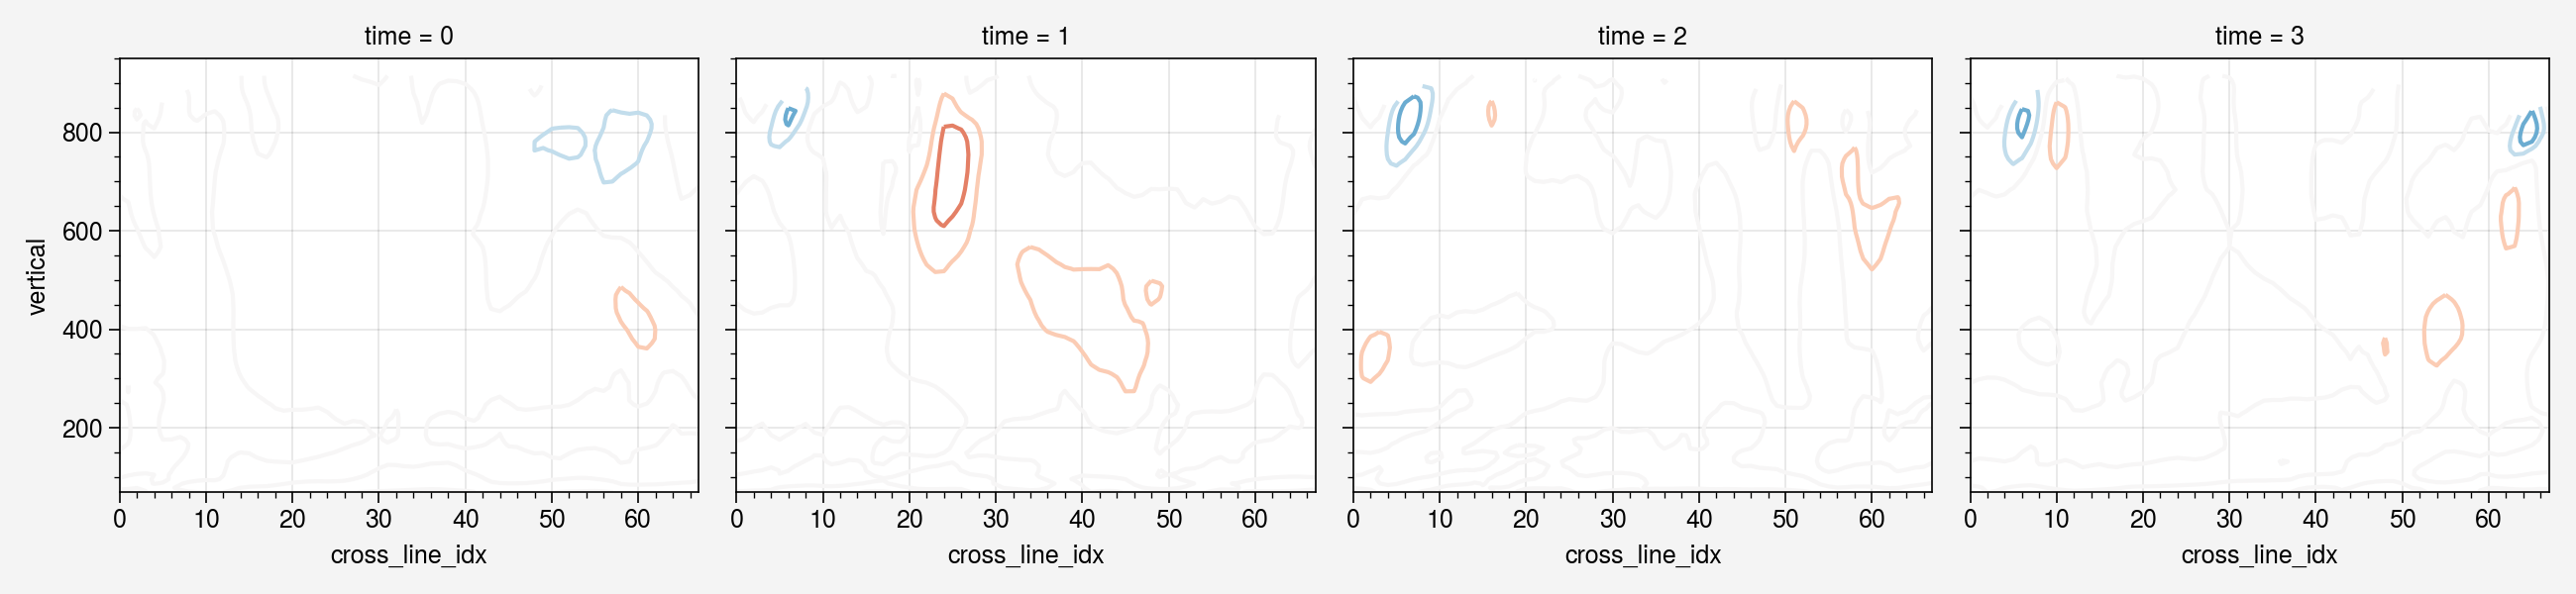

In [7]:
# urban
dt_ens_mean_var['wa'][0].plot.contour(col='time')

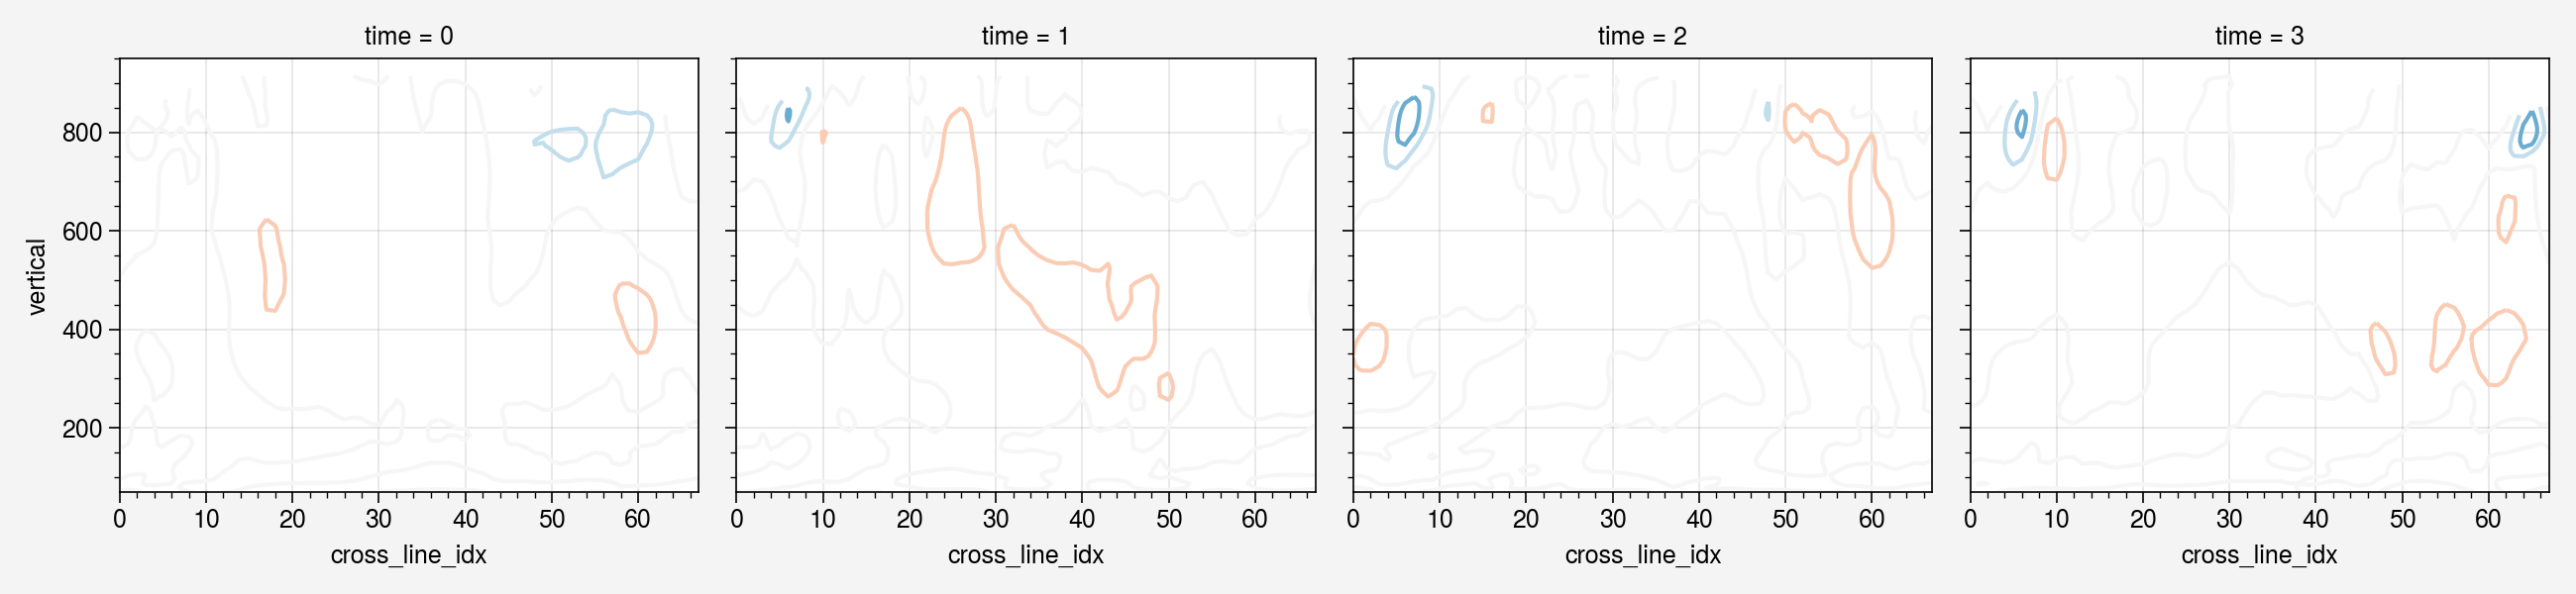

In [8]:
# nourban
dt_ens_mean_var['wa'][1].plot.contour(col='time')

## 3. Figure

### 3.1 Options

In [7]:
# Parameters to change (plot) -------------------
cmap = proplot.Colormap('ColdHot')

# fig features
fig_array = [[1, 2, 3, 4],
             [5, 6, 7, 8]
            ]
graphic_no = 8

# graphic vmin, vmax and norms
vmin = -6 # consider lower limit above
vmax = 6 # consider upper limit above

clevs_total = np.arange(-6, 6.1, 1)
norm = BoundaryNorm(clevs_total,
                    ncolors=cmap.N, 
                    clip=True)
ticks = np.arange(-6, 6.1, 2)

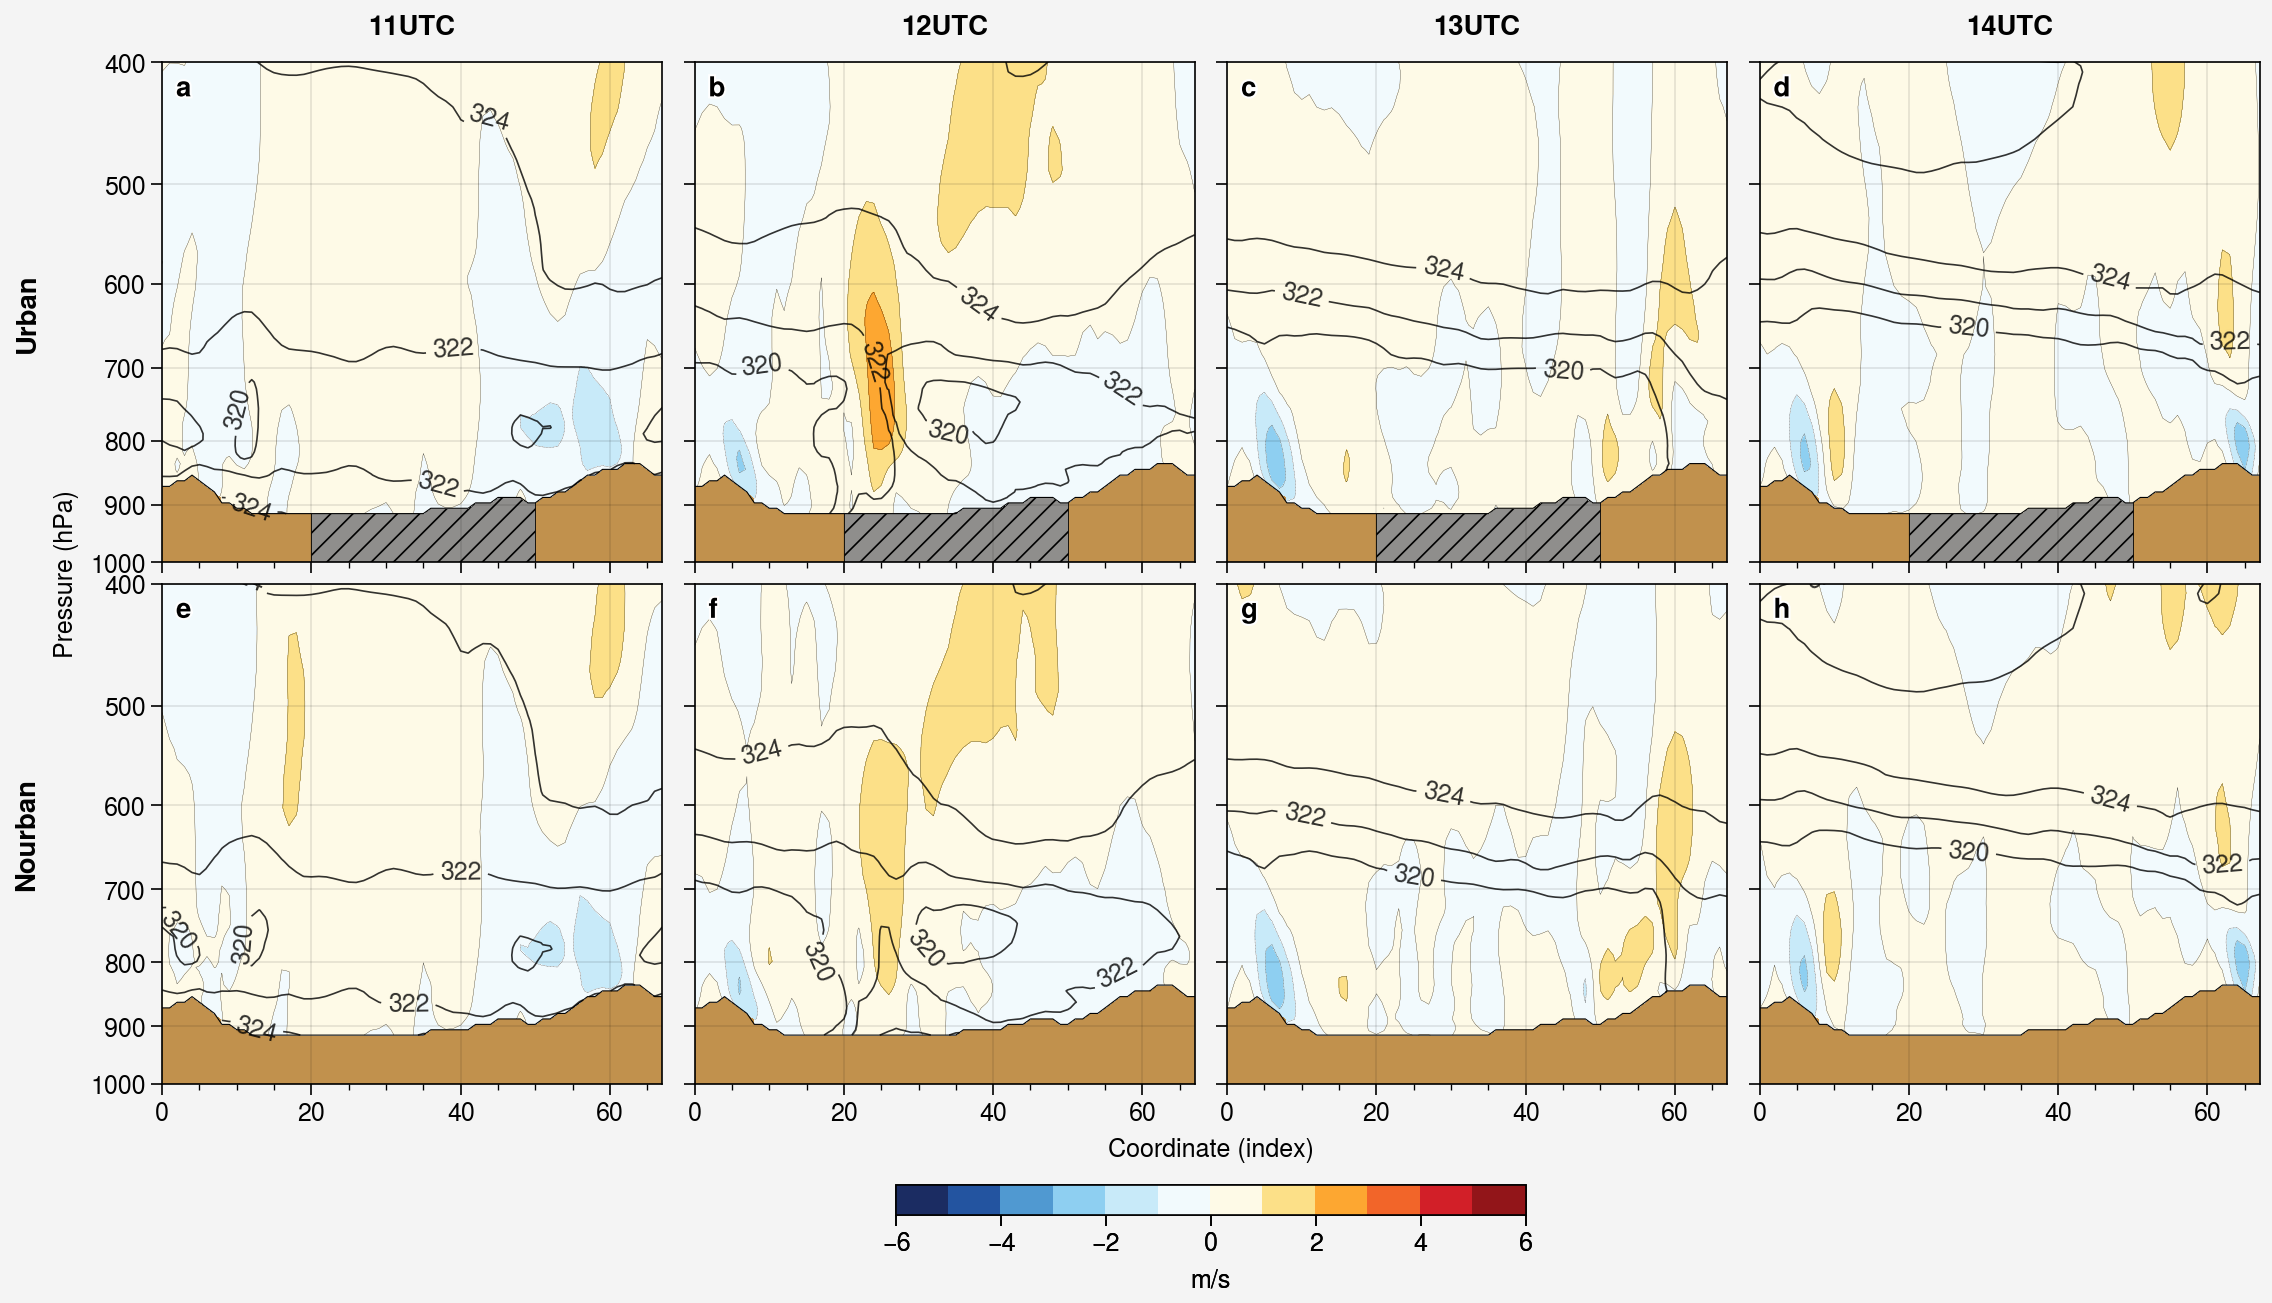

In [10]:
# Create Figure -------------------------
fig, axs = proplot.subplots(fig_array, 
                            
                            includepanels=True,
                            hspace=0.86,
                            wspace=1.3,
                            sharey=3)

# format whole figure
axs.format(abcloc='ul',
           abc=True,)

axs.format(rowlabels=['Urban', 'Nourban'],
           collabels=['11UTC', '12UTC', '13UTC', '14UTC']
           )

axs.format(ylim=(1000, 400), yscale='log',
           ylabel='Pressure (hPa)', ylocator=100,
           xlabel='Coordinate (index)')

x_fill = [20, 30, 40, 50]
y_fill = [800, 800, 800, 800]

for t in range(graphic_no):
    
    if t < graphic_no/2:
        dt_ens = dt_ens_mean_var['wa'][0]
        dt_ens_theta = dt_ens_mean_var['theta_e'][0]
        
        i = t
    else:
        dt_ens = dt_ens_mean_var['wa'][1]
        dt_ens_theta = dt_ens_mean_var['theta_e'][1]
        
        i = t-int(graphic_no/2)
        
    cut = -0.05
    mesh = axs[t].contourf(dt_ens[i]['cross_line_idx'], 
                    dt_ens[i]['vertical'],#[::-1],
                    dt_ens[i], 
                    cmap = cmap,
                    cmap_kw={'cut': cut},
                    linewidth = 0.1,
                    norm=norm,
                    zorder = 0.2,
                    alpha=1)
    
    contour_levels = np.array([320, 322, 324, 326, 328, 330,
                               332, 334, 336, 338, 340, 346, 352,
                               358, 364])
    
    contour = axs[t].contour(dt_ens_theta[i]['cross_line_idx'], 
                    dt_ens_theta[i]['vertical'],#[::-1],
                    dt_ens_theta[i], 
                    levels = contour_levels,
                    zorder = 0.3,
                    alpha=0.8,
                   colors='black',
                   labels=True,
                   lw = 0.6)
    
    axs[t].set_facecolor("#c1914d")
    
    if t < graphic_no/2:
        axs[t].fill_between(x_fill, 1000, y_fill,
                            interpolate=True, zorder=0.1,
                            color='#8f8e8c', hatch="///",
                            edgecolor="k", lw=0.3)
    
    # bottom hgt line
    axs[t].plot(range(len(dt_ens['cross_line_idx'])),
                 bottom_hgt_list,
                 color='k',
                 lw=0.4)
    
# colorbar
cbar = fig.colorbar(mesh,
                    label='m/s',
                    ticks = ticks,
                    loc = 'b',
                    shrink = 0.3,
                    width = 0.15
                    #col=2
                   )

#save figure
plt.savefig(r'pictures/FigureS9.jpeg',
            bbox_inches='tight', optimize=True,
            progressive=True, dpi=1000)

## 4. Topography-Prec. Diff. Map

### 4.1 Extra Datasets

In [8]:
proj_data = xr.open_dataset(r'data/spring_lin_urban_PRCP_wrfout_d03_2014-05-05.nc')['PRCP']
# assign projection and dim info
proj_data = proj_data.rio.write_crs(proj_data.attrs['pyproj_srs'])
proj_data = proj_data.rio.set_spatial_dims(x_dim='west_east',
                             y_dim='south_north')

In [9]:
prcp_diff = xr.open_dataset('data/PRCP_spring_diff_d03.nc')['PRCP']
# assign projection and dim info
prcp_diff = prcp_diff.rio.write_crs(prcp_diff.attrs['pyproj_srs'])
prcp_diff = prcp_diff.rio.set_spatial_dims(x_dim='west_east',
                             y_dim='south_north')

### 4.2 ua and va datasets

In [10]:
# general options
run_season = 'spring'
general_path = 'data'
start_utc = 11
end_utc = 15

# ensemble members
micro_options = [
    'lin',
    'thompson',
    'wsm6'
]

luse_options = [
    'urban',
    'nourban'
]

### 4.3 Plot

In [11]:
# add shapefiles
turkey_district_shape = r'data/shapefiles/ankara_province_shape.shp'
turkey_province_shape = r'data/shapefiles/Iller_HGK_6360_Kanun_Sonrasi.shp'

In [12]:
luse_path = 'lu_index'
luse_var = 'LU_INDEX'
urban_luse_border = xr.open_dataset(fr'{general_path}/{luse_path}/urban_luse.nc')[luse_var]
nourban_luse_border = xr.open_dataset(fr'{general_path}/{luse_path}/nourban_luse.nc')[luse_var]

In [13]:
# Parameters to change (plot) -------------------

# projection
proj = proj_data.rio.crs.to_dict()
globe = cartopy.crs.Globe(ellipse='sphere', semimajor_axis=6370000, semiminor_axis=6370000)
lcc = cartopy.crs.LambertConformal(globe=globe, # important!
                            central_longitude=proj['lon_0'], 
                            central_latitude=proj['lat_0'],
                            standard_parallels=(proj['lat_1'], proj['lat_2']),
                            )

# fig features
fig_array = [[1, 2, 3],
             [4, 5, 6],
            ]
graphic_no = 6


In [14]:
lat1, lon1 = 40.05448889, 32.36649722
lat2, lon2 = 39.80196944, 33.08456944

line_dt = xr.open_dataset(r'data/spring_lin_nourban_theta_e_wrfout_d03_2014-05-05.nc')
line_lon = line_dt.sel(xy_loc=[0, 20, 40, 60])['lon'].values
line_lat = line_dt.sel(xy_loc=[0, 20, 40, 60])['lat'].values

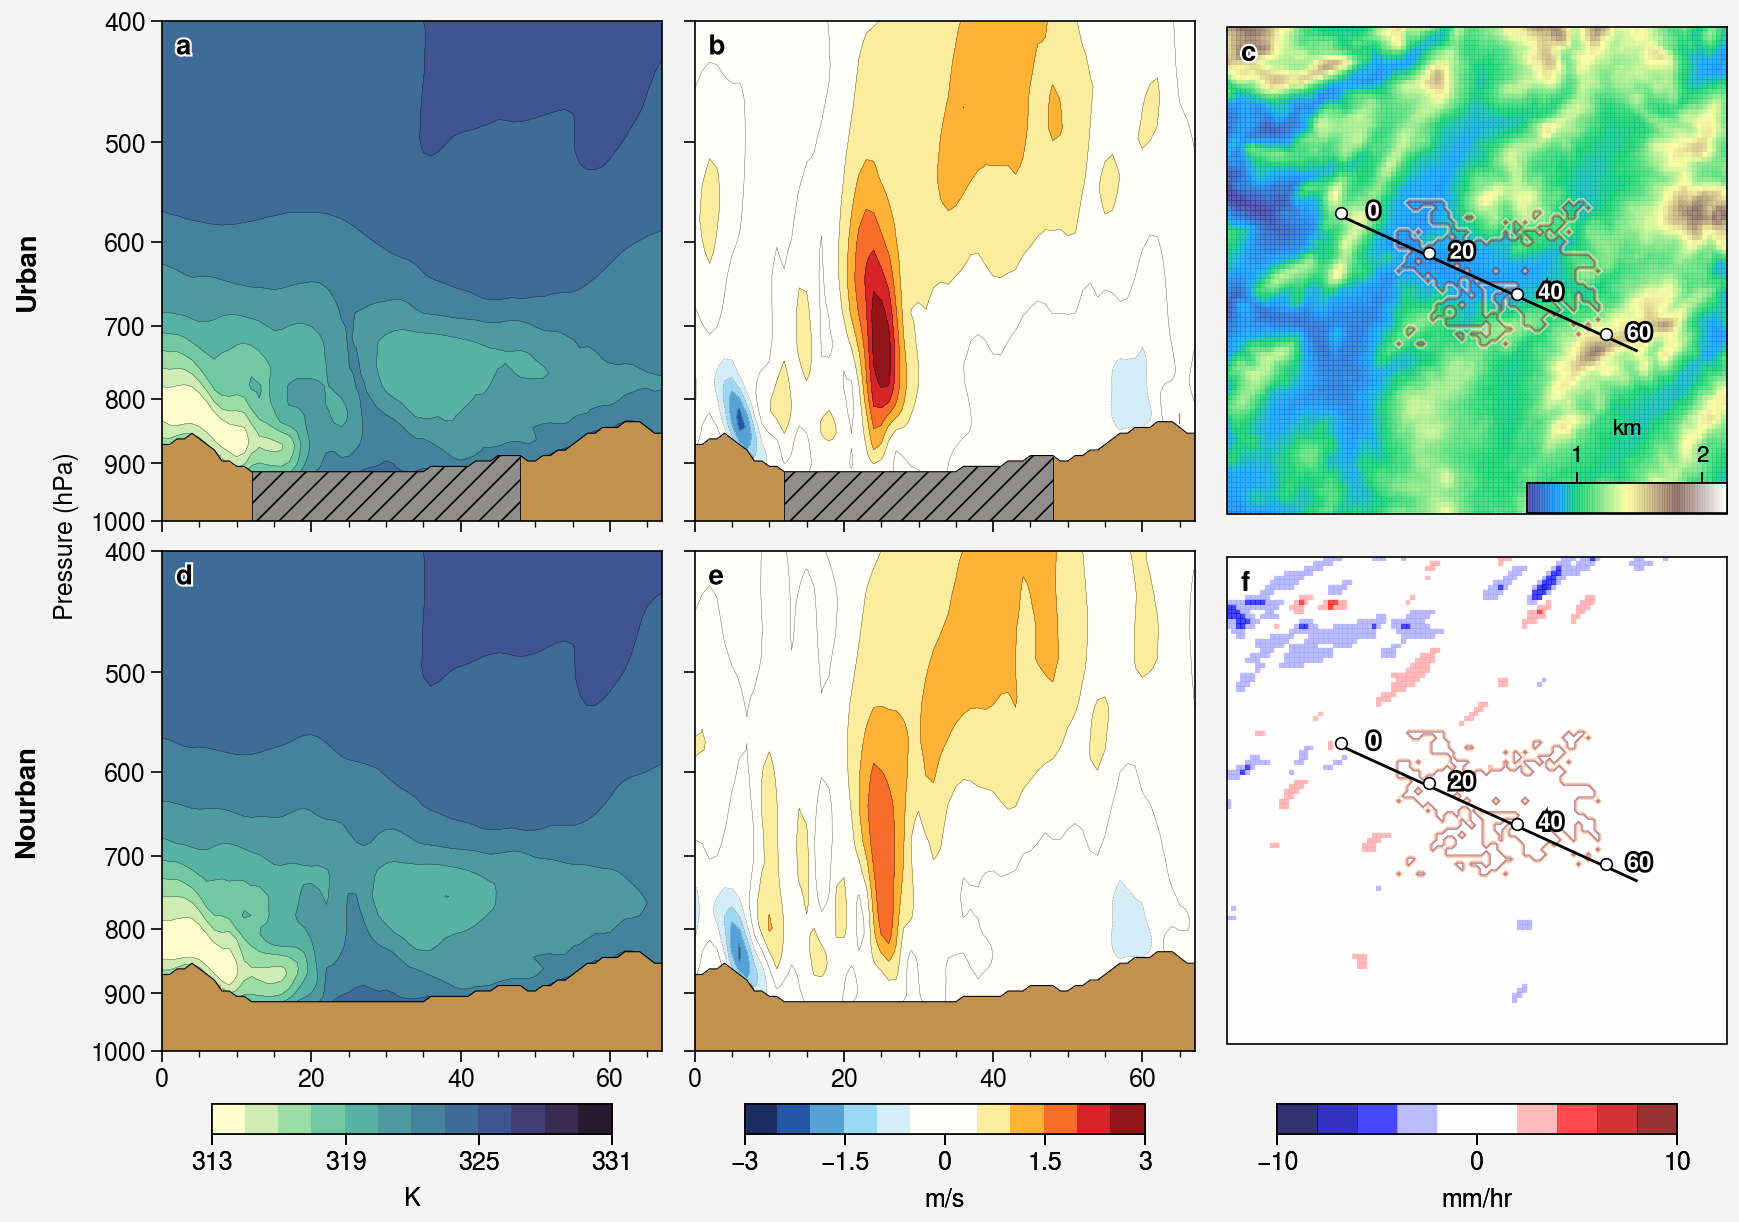

In [16]:
# Create Figure -------------------------
fig2, axs2 = proplot.subplots(fig_array, 
                            proj=[None, None, lcc, None, None, lcc],
                            includepanels=True,
                            hspace=1.5,
                            wspace=1.3,
                            span=True,
                            sharex=4,
                            sharey=4
                             )

# format whole figure
axs2.format(abcloc='ul',
           abc=True,
            )

# ankara urban limits
lonlim=(32.1, 33.3)
latlim=(39.5, 40.4)

axs2[2].format(lonlim=lonlim, 
           latlim=latlim,
           labels=False, 
           longrid=False, 
           latgrid = False)
axs2[5].format(lonlim=lonlim, 
           latlim=latlim,
           labels=False, 
           longrid=False, 
           latgrid = False) 

for i in [0, 1, 3, 4]:
    axs2[i].format(grid=False)
    
#axs2[1].sharey(axs2[0])
#axs2[3].sharey(axs2[4])

    
cut = -0.1
x_fill = [12, 20, 30, 40, 48]
y_fill = [800, 800, 800, 800, 800]

for t in range(6):
    
    if t in [0, 3]:
        cmap = proplot.Colormap('deep')
        clevs_total = np.arange(313, 331.5, 1.5)
        norm = BoundaryNorm(clevs_total,
                            ncolors=cmap.N, 
                            clip=True)
        ticks = np.arange(313, 331.1, 6)
        
    elif t in [1, 4]:
        cmap = proplot.Colormap('ColdHot')
        clevs_total = np.arange(-3, 3.1, 0.5)
        norm = BoundaryNorm(clevs_total,
                            ncolors=cmap.N, 
                            clip=True)
        ticks = np.arange(-3, 3.1, 1.5)
        
    #############3
    
    if t in [2, 5]:
        # urban boundary contours
        contour = axs2[t].contour(urban_luse_border['lon'], 
                            urban_luse_border['lat'],
                            urban_luse_border,
                            linewidth = 0.1
                            )
    if t == 2:
        
        cmap = proplot.Colormap('terrain')
        clevs_total = np.arange(0.6, 2.21, 0.02)
        norm = BoundaryNorm(clevs_total,
                            ncolors=cmap.N, 
                            clip=True)
        ticks = np.array([1, 2])
        
        mesh = axs2[t].pcolormesh((hgt_data/1000)['lon'], 
                            (hgt_data/1000)['lat'],
                            (hgt_data/1000), 
                            cmap = cmap,
                            norm=norm,
                            zorder = 0.2,
                            alpha=0.8)
        # colorbar
        cbar = axs2[t].colorbar(mesh,
                    label='km',
                    ticks = ticks,
                    loc = 'b',
                    alpha=0.5,
                    labelsize = 8,
                    ticklabelsize = 8,
                    labelloc = 'top',
                    ticklocation = 'top',
                    align = 'right',
                    space = -1.5,
                    shrink=0.4,
                    width = 0.15,
                    #pad = -3.5,
                    col=2
                   )
    
    elif t == 5:
        
        cmap = proplot.Colormap('seismic')
        clevs_total = np.arange(-10, 10.1, 2)
        norm = BoundaryNorm(clevs_total,
                            ncolors=cmap.N, 
                            clip=True)
        ticks = np.arange(-10, 10.1, 10)
        
        mesh = axs2[t].pcolormesh(prcp_diff['lon'], 
                            prcp_diff['lat'],
                            prcp_diff, 
                            cmap = cmap,
                            cmap_kw={'cut': -0.2},
                            norm=norm,
                            zorder = 0.2,
                            alpha=0.8)
        # colorbar
        cbar = axs2[t].colorbar(mesh,
                    label='mm/hr',
                    ticks = ticks,
                    loc = 'b',
                    shrink=0.8,
                    width = 0.15,
                    col=2
                   )
        
    elif t == 0:
        dt_ens_theta = dt_ens_mean_var['theta_e'][0][1]
        
        mesh = axs2[t].contourf(dt_ens_theta['cross_line_idx'], 
                    dt_ens_theta['vertical'],#[::-1],
                    dt_ens_theta, 
                    cmap = cmap,
                    linewidth = 0.1,
                    #cmap_kw={'cut': cut},
                    norm=norm,
                    zorder = 0.2,
                    alpha=1)
        axs2[t].set_facecolor("#c1914d") 
        axs2[t].fill_between(x_fill, 1000, y_fill,
                             interpolate=True, zorder=0.1,
                             color='#8f8e8c', hatch="///",
                             edgecolor="k", lw=0.3)
        
        # bottom hgt line
        axs2[t].plot(range(len(dt_ens_theta['cross_line_idx'])),
                     bottom_hgt_list,
                     color='k',
                     lw=0.4)
        
    elif t == 1:
        dt_ens = dt_ens_mean_var['wa'][0][1]
        
        mesh = axs2[t].contourf(dt_ens.sel(vertical=slice(1000, 390))['cross_line_idx'], 
                    dt_ens.sel(vertical=slice(1000, 390))['vertical'],#[::-1],
                    dt_ens.sel(vertical=slice(1000, 390)), 
                    cmap = cmap,
                    linewidth = 0.1,
                    cmap_kw={'cut': cut},
                    norm=norm,
                    zorder = 0.2,
                    alpha=1)
        axs2[t].set_facecolor("#c1914d")
        axs2[t].fill_between(x_fill, 1000, y_fill,
                             interpolate=True, zorder=0.1,
                             color='#8f8e8c', hatch="///",
                             edgecolor="k", lw=0.3)
        
        # bottom hgt line
        axs2[t].plot(range(len(dt_ens['cross_line_idx'])),
                     bottom_hgt_list,
                     color='k',
                     lw=0.4)

    elif t == 3:
        dt_ens_theta = dt_ens_mean_var['theta_e'][1][1]
        
        mesh = axs2[t].contourf(dt_ens_theta.sel(vertical=slice(1000, 390))['cross_line_idx'], 
                    dt_ens_theta.sel(vertical=slice(1000, 390))['vertical'],#[::-1],
                    dt_ens_theta.sel(vertical=slice(1000, 390)), 
                    cmap = cmap,
                    linewidth = 0.1,
                    #cmap_kw={'cut': cut},
                    norm=norm,
                    zorder = 0.2,
                    alpha=1)
        axs2[t].set_facecolor("#c1914d")
        
        # bottom hgt line
        axs2[t].plot(range(len(dt_ens_theta['cross_line_idx'])),
                     bottom_hgt_list,
                     color='k',
                     lw=0.4)
        
        # colorbar
        cbar = axs2[t].colorbar(mesh,
                    label='K',
                    ticks = ticks,
                    loc = 'b',
                    shrink=0.8,
                    width = 0.15,
                    col=1
                    
                   )
        
    elif t == 4:
        dt_ens = dt_ens_mean_var['wa'][1][1]
        
        mesh = axs2[t].contourf(dt_ens.sel(vertical=slice(1000, 390))['cross_line_idx'], 
                    dt_ens.sel(vertical=slice(1000, 390))['vertical'],#[::-1],
                    dt_ens.sel(vertical=slice(1000, 390)), 
                    cmap = cmap,
                    linewidth = 0.1,
                    cmap_kw={'cut': cut},
                    norm=norm,
                    zorder = 0.2,
                    alpha=1)
        axs2[t].set_facecolor("#c1914d")
        
        # bottom hgt line
        axs2[t].plot(range(len(dt_ens['cross_line_idx'])),
                     bottom_hgt_list,
                     color='k',
                     lw=0.4)
        
        
        # colorbar
        cbar = axs2[t].colorbar(mesh,
                    label='m/s',
                    ticks = ticks,
                    loc = 'b',
                    shrink=0.8,
                    width = 0.15,
                    col=1,
                    
                   )
        
axs2.format(rowlabels=['Urban', 'Nourban'],
           )

axs2[0:2].format(ylim=(1000, 400), yscale='log',
           ylabel='Pressure (hPa)', ylocator=100,
           xlabel='')
axs2[3:5].format(ylim=(1000, 400), yscale='log',
           ylabel='Pressure (hPa)', ylocator=100,
           xlabel='')

# lines
for i in [2, 5]:
    axs2[i].plot((lon1, lon2), (lat1, lat2),
                 color='black', 
                 transform = cartopy.crs.PlateCarree(), 
                 zorder = 6, 
                 linewidth = 1, 
                 )

    axs2[i].scatter(line_lon, line_lat,  
                   color='white', 
                   transform = cartopy.crs.PlateCarree(),
                   zorder = 7,
                   s = 70,
                   marker = '.',
                   markeredgecolor='k')
    
    label_list = [0, 20, 40, 60]
    for j in range(len(label_list)):
        axs2[i].text(line_lon[j]+0.08, line_lat[j],
                 s = label_list[j],
                 size = 8,
                 border=True,
                 bordercolor='black',
                 borderwidth=2,
                 color='white', 
                 transform = cartopy.crs.PlateCarree(),
                 va='center', 
                 weight='bold', 
                 ha = 'center', 
                 path_effects=[path_effects.Stroke(linewidth=2, foreground='black'),
                               path_effects.Normal()]
                 )
        
#save figure
plt.savefig(r'pictures/Figure8.jpeg',
            bbox_inches='tight', optimize=True,
            progressive=True, dpi=1000)